In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'


Mounted at /content/drive
/content/drive/MyDrive/dl-project


In [2]:
!pip install ray[tune]
!pip install transformers
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# copy dataset from google drive to the actual machine
# !rm -rf /content/data/

import os 
DATA_FOLDER = '/content/data/shopee-product-matching/'
if not os.path.isdir(DATA_FOLDER):    
    !mkdir /content/data/
    !cp /content/drive/MyDrive/dl-project/shopee-product-matching.zip /content/data/shopee-product-matching.zip
    !unzip -q /content/data/shopee-product-matching.zip -d /content/data/shopee-product-matching
    !cp /content/drive/MyDrive/dl-project/data/train.csv /content/data/shopee-product-matching/train.csv
    !cp /content/drive/MyDrive/dl-project/data/train80.csv /content/data/shopee-product-matching/train80.csv
    !cp /content/drive/MyDrive/dl-project/data/valid20.csv /content/data/shopee-product-matching/valid20.csv

In [4]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from modules.datasets.TextContrastiveLossShopeeDataset import TextContrastiveLossShopeeDataset
from modules.losses.ContrastiveLoss import ContrastiveLoss
from modules.models.SiameseNet import SiameseNet
from modules.distances.CosineDistance import CosineDistance
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from transformers import AutoTokenizer
from modules.models.BERTPreTrainedEmbeddingsShopeeNet import BERTPreTrainedEmbeddingsShopeeNet
from modules.models.TextShopeeNet import TextShopeeNet
import modules.utils.dataset_utils as dataset_utils
from modules.utils.CommonVIsualizer import CommonVisualizer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import faiss

In [5]:
train_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='train80.csv')
train_df = dataset_utils.add_target(train_df)

valid_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='valid20.csv')
valid_df = dataset_utils.add_target(valid_df)


all_df = train_df.append(valid_df, ignore_index=True)
print(f"All shape {all_df.shape}")
print(f"Train shape {train_df.shape}")
print(f"Valid shape {valid_df.shape}")

All shape (34250, 7)
Train shape (27399, 7)
Valid shape (6851, 7)


<ipython-input-5-e79de579a42f>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = train_df.append(valid_df, ignore_index=True)


In [6]:
# !rm  ./contrastive_loss_data_train.csv
# !rm  ./contrastive_loss_data_valid.csv

CONTRASTIVE_LOSS_DATASET_PATH_TRAIN = './contrastive_loss_data_train.csv'
train_cl_df = dataset_utils.get_contrastive_loss_dataset(train_df, read_path=CONTRASTIVE_LOSS_DATASET_PATH_TRAIN)
train_cl_df.to_csv(CONTRASTIVE_LOSS_DATASET_PATH_TRAIN, index=False)

CONTRASTIVE_LOSS_DATASET_PATH_VALID = './contrastive_loss_data_valid.csv'
valid_cl_df = dataset_utils.get_contrastive_loss_dataset(valid_df, read_path=CONTRASTIVE_LOSS_DATASET_PATH_VALID)
valid_cl_df.to_csv(CONTRASTIVE_LOSS_DATASET_PATH_VALID, index=False)
print(f"Contrastive loss train shape {train_cl_df.shape}")
print(f"Contrastive loss valid shape {valid_cl_df.shape}")

Contrastive loss train shape (54798, 7)
Contrastive loss valid shape (13702, 7)


In [7]:
class CFG:
    # IMG_SZ = 256
    # TRAIN_RATIO = 0.8
    EPOCHS = 10
    MARGIN = 0.75
    DISTANCE = CosineDistance()



In [8]:
trans = transforms.Compose([])


train_dataset = TextContrastiveLossShopeeDataset(
    train_cl_df['title_1'].values,
    train_cl_df['title_2'].values,
    train_cl_df['label'].values,
    trans,
)

valid_dataset = TextContrastiveLossShopeeDataset(
    valid_cl_df['title_1'].values,
    valid_cl_df['title_2'].values,
    valid_cl_df['label'].values,
    trans,
)


print(len(train_dataset))
print(len(valid_dataset))

54798
13702


In [9]:
from ray.air import session

def get_tokenizer(config):
    return AutoTokenizer.from_pretrained(config["model_name"])

def get_model(config):
    return TextShopeeNet(model_name=config["model_name"],
                          fc_dim=config["fc_dim"],
                          freeze=config["freeze"], 
                          dropout=config["dropout"]
                        )


def train_model(config, use_tune=True):

    tokenizer = get_tokenizer(config)

    def collate_fn(batch):
        xs_1, xs_2, ys = zip(*batch)

        xs_1 = tokenizer(list(xs_1), padding=True, truncation=True, return_tensors="pt")
        xs_2 = tokenizer(list(xs_2), padding=True, truncation=True, return_tensors="pt")

        return xs_1, xs_2, torch.stack(ys)
    
    model = get_model(config)
    
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, _ = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    siamese_net = SiameseNet(model)
    if torch.cuda.device_count() > 1:
        siamese_net = torch.nn.DataParallel(siamese_net)
    siamese_net.to(device)
    criterion = ContrastiveLoss(device=device, m=CFG.MARGIN, distance=CFG.DISTANCE)
    optimizer = optim.Adam(siamese_net.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=config['factor'])

    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           _, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        optimizer.load_state_dict(optimizer_state)
    # Datasets and data loaders
    training_sampler = torch.utils.data.SubsetRandomSampler(
        torch.arange(len(train_dataset))[:int(0.4*len(train_dataset))]
    )
    valid_sampler = torch.utils.data.SubsetRandomSampler(
        torch.arange(len(valid_dataset))[:int(0.4*len(valid_dataset))]
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=training_sampler,
        batch_size=int(config["batch_size"]),
        # shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=int(config["batch_size"]),
        # shuffle=True,
        sampler=valid_sampler,
        num_workers=0,
        collate_fn=collate_fn,
    )

    train_losses = []
    valid_losses = []
    ## Training loop: training + validation
    for epoch in range(CFG.EPOCHS):
        ## Training
        train_loss = 0.0
        epoch_steps = 0
        model.train()
        siamese_net.train()
        train_enumerator = enumerate(train_loader, 0)
        if not use_tune:
            train_enumerator = tqdm(train_enumerator)
        for i, data in train_enumerator:
            input_1, input_2, target = data
            input_1, input_2, target = input_1.to(device), input_2.to(device), target.to(device)
            optimizer.zero_grad()
            output_1, output_2 = siamese_net(input_1, input_2)
            loss = criterion(output_1, output_2, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1
            if i % 50 == 0:
                print("[%d, %5d / %d batches] loss: %.3f" % (epoch + 1, i + 1, len(train_loader),
                                                train_loss / epoch_steps))
        

        ## Validation
        val_loss = 0.0
        model.eval()
        siamese_net.eval()
        valid_enumerator = enumerate(valid_loader, 0)
        if not use_tune:
            valid_enumerator = tqdm(valid_enumerator)
        for i, data in valid_enumerator:
            with torch.no_grad():
                input_1, input_2, target = data
                input_1, input_2, target = input_1.to(device), input_2.to(device), target.to(device)
                output_1, output_2 = siamese_net(input_1, input_2)
                loss = criterion(output_1, output_2, target)
                val_loss += loss.cpu().numpy()
        if use_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(
                val_loss=(val_loss / len(valid_loader)),
                train_loss=(train_loss / len(train_loader))
                )
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
    if not use_tune:
        return model, train_losses, valid_losses

In [10]:
config_1 = {
    "model_name": tune.choice(["bert-base-uncased"]),
    "lr": tune.choice([1e-5, 1e-4, 1e-3]),
    "fc_dim": tune.choice([512, 1024]),
    "freeze": tune.choice([True]),
    "dropout": tune.choice([0.1, 0.2, 0.3]),
    "batch_size": tune.choice([32, 64]),
    "factor": tune.choice([0.1, 0.5, 0.9]),
}

config_2 = {
    "model_name": tune.choice(["sentence-transformers/paraphrase-xlm-r-multilingual-v1"]),
    "lr": tune.choice([1e-5, 1e-4, 1e-3]),
    "fc_dim": tune.choice([512, 1024]),
    "freeze": tune.choice([True]),
    "dropout": tune.choice([0.1, 0.2, 0.3]),
    "batch_size": tune.choice([32, 64]),
    "factor": tune.choice([0.1, 0.5, 0.9]),
}

def run_hyperparameter_search(num_samples, config, max_epochs, cpus_per_trial, gpus_per_trial, name=None, resume=None):
    scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=max_epochs,
        grace_period=2,
        reduction_factor=3)
    reporter = CLIReporter(
        metric_columns=["train_loss", "val_loss", "training_iteration"]
        )
    result = tune.run(
        train_model,
        resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        name=name,
        scheduler=scheduler,
        progress_reporter=reporter,
        local_dir="/root/ray_results",
        resume=resume,
        raise_on_failed_trial=False,)
    return result



In [11]:
result_1 = run_hyperparameter_search(num_samples=5, config=config_1, max_epochs=10, cpus_per_trial=1, gpus_per_trial=0.2, resume=True, name='train_model_2023-04-29_08-32-50')

2023-04-29 13:04:11,014	INFO worker.py:1625 -- Started a local Ray instance.
2023-04-29 13:04:12,067	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
/usr/local/lib/python3.10/dist-packages/ray/tune/experiment/experiment.py:170: UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
  warnings.warn(
2023-04-29 13:04:12,245	WARNING trial_runner.py:382 -- Attempting to resume experiment from /root/ray_results/train_model_2023-04-29_08-32-50. This will ignore any new changes to the specification.
2023-04-29 13:04:12,247	INFO trial_runner.py:386 -- Using the newest experiment state file found within the experiment directory: experiment_state-2023-04-29_13-00-04.json
2023-04-29 13:04:12,533	INFO tune.py:945 -- Total run time: 0.46 seconds (0.00 seconds for the tuning loop).


== Status ==
Current time: 2023-04-29 13:04:12 (running for 00:00:00.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 6.000: None | Iter 2.000: None
Logical resource usage: 0/8 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_model_2023-04-29_08-32-50
Number of trials: 5/5 (5 TERMINATED)
+-------------------------+------------+--------------------+--------------+-----------+----------+----------+----------+--------+-------------------+--------------+------------+----------------------+
| Trial name              | status     | loc                |   batch_size |   dropout |   factor |   fc_dim | freeze   |     lr | model_name        |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+--------------------+--------------+-----------+----------+----------+----------+--------+-------------------+--------------+------------+----------------------|
| train_model_6d58f_00003 | TERMINATED | 172.28.0.12:156226 |           32 |       0.2 |      0

In [12]:
result_2 = run_hyperparameter_search(num_samples=5, config=config_2, max_epochs=10, cpus_per_trial=1, gpus_per_trial=0.2, resume=True, name='train_model_2023-04-29_09-24-56')

2023-04-29 13:45:56,474	WARNING trial_runner.py:382 -- Attempting to resume experiment from /root/ray_results/train_model_2023-04-29_09-24-56. This will ignore any new changes to the specification.
2023-04-29 13:45:56,475	INFO trial_runner.py:386 -- Using the newest experiment state file found within the experiment directory: experiment_state-2023-04-29_12-58-11.json
2023-04-29 13:45:56,714	INFO tune.py:945 -- Total run time: 0.32 seconds (0.00 seconds for the tuning loop).


== Status ==
Current time: 2023-04-29 13:45:56 (running for 00:00:00.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 6.000: None | Iter 2.000: None
Logical resource usage: 0/8 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_model_2023-04-29_09-24-56
Number of trials: 5/5 (5 TERMINATED)
+-------------------------+------------+--------------------+--------------+-----------+----------+----------+----------+--------+----------------------+--------------+------------+----------------------+
| Trial name              | status     | loc                |   batch_size |   dropout |   factor |   fc_dim | freeze   |     lr | model_name           |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+--------------------+--------------+-----------+----------+----------+----------+--------+----------------------+--------------+------------+----------------------|
| train_model_b4d76_00003 | TERMINATED | 172.28.0.12:170808 |           64 |       0.1

In [13]:
def get_best_trial_checkpoint_and_losses(result):
    best_trial = result.get_best_trial("val_loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final training loss: {}".format(best_trial.last_result["train_loss"]))
    print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))

    my_trials = [ trial for trial in list(result.trial_dataframes.keys()) if str(best_trial) in trial]
    # print(my_trials)
    best_checkpoint = result.get_best_checkpoint(trial=my_trials[0], metric="val_loss", mode="min")
    train_losses = result.trial_dataframes[my_trials[0]]["train_loss"].values
    val_losses = result.trial_dataframes[my_trials[0]]["val_loss"].values
    print(f"Train losses: {val_losses}")
    print(f"Validation losses: {val_losses}")
    return best_trial, best_checkpoint, train_losses, val_losses

In [14]:
best_trial_1, best_checkpoint_1, train_losses_1, val_losses_1 = get_best_trial_checkpoint_and_losses(result_1)
print("-------------")
best_trial_2, best_checkpoint_2, train_losses_2, val_losses_2 = get_best_trial_checkpoint_and_losses(result_2)

Best trial config: {'model_name': 'bert-base-uncased', 'lr': 0.0001, 'fc_dim': 512, 'freeze': True, 'dropout': 0.2, 'batch_size': 32, 'factor': 0.1}
Best trial final training loss: 0.08520614408554822
Best trial final validation loss: 0.10204335189489432
Train losses: [0.14144444 0.13418773 0.12828817 0.1237081  0.11840783 0.11277875
 0.10948282 0.10625794 0.10398577 0.10204335]
Validation losses: [0.14144444 0.13418773 0.12828817 0.1237081  0.11840783 0.11277875
 0.10948282 0.10625794 0.10398577 0.10204335]
-------------
Best trial config: {'model_name': 'sentence-transformers/paraphrase-xlm-r-multilingual-v1', 'lr': 0.001, 'fc_dim': 1024, 'freeze': True, 'dropout': 0.1, 'batch_size': 32, 'factor': 0.9}
Best trial final training loss: 0.0794439181032842
Best trial final validation loss: 0.109001666264132
Train losses: [0.13084796 0.11401832 0.10911385 0.10839689 0.10898854 0.10922992
 0.10915205 0.10877965 0.1095024  0.10900167]
Validation losses: [0.13084796 0.11401832 0.10911385 0.1

In [27]:
def get_model_name(config):
    if config["model_name"] == 'bert-base-uncased':
        return "BERT"
    else:
        return "XLM"
    
def losses_visualization(best_trial, train_losses, val_losses, num):
    visualizer = CommonVisualizer()
    model_name = get_model_name(best_trial.config)
    visualizer.plt_losses(train_losses, val_losses, model_name, 'Contrastive loss', f'./final-charts/text-constrastive-{num}-{model_name}.png')


def save_and_load_model(best_trial, best_checkpoint, num):
    name = get_model_name(best_trial.config)
    check_path = f'./best_contrastive_loss_text_model-{num}-{name}.pt'
    best_model = get_model(best_trial.config)

    best_checkpoint_dir = best_checkpoint.to_directory(path="directory")
    model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
    best_model.load_state_dict(model_state)
    torch.save(best_model.state_dict(), check_path)
    best_model.load_state_dict(torch.load(check_path))
    return best_model

# def load_model(path):
#     best_model = 
#     best_model.load_state_dict(torch.load(check_path))
#     return best_model


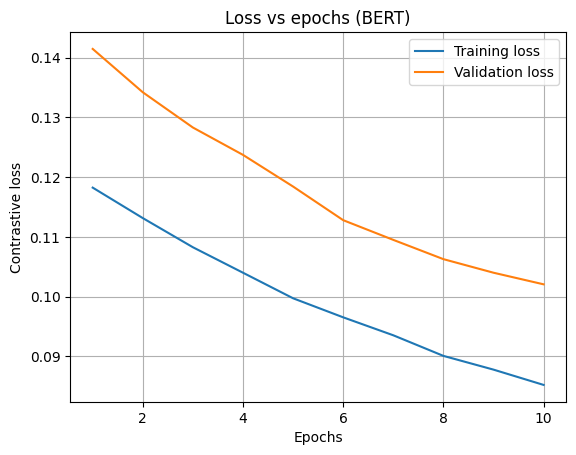

In [28]:
losses_visualization(best_trial_1, train_losses_1, val_losses_1, 1)

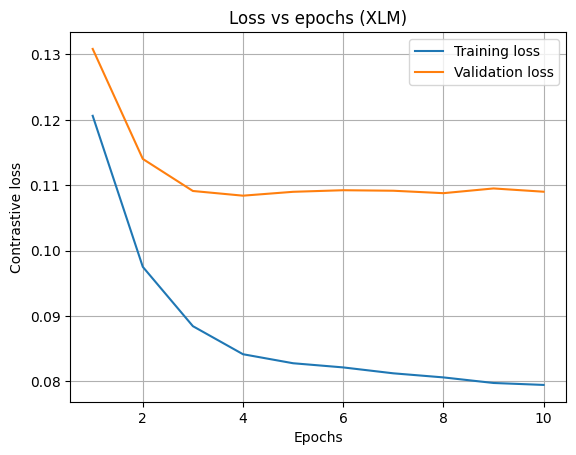

In [29]:
losses_visualization(best_trial_2, train_losses_2, val_losses_2, 2)

In [30]:
best_model_1 = save_and_load_model(best_trial_1, best_checkpoint_1, 1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
best_model_2 = save_and_load_model(best_trial_2, best_checkpoint_2, 2)

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_1.to(DEVICE)
best_model_2.to(DEVICE)

from modules.datasets.TextShopeeDataset import TextShopeeDataset
tokenizer_1 = AutoTokenizer.from_pretrained(best_trial_1.config["model_name"])
tokenizer_2 = AutoTokenizer.from_pretrained(best_trial_2.config["model_name"])
 
def my_collate_fn_1(data):
    inputs = tokenizer_1(data, padding=True, return_tensors="pt")
    return inputs

 
def my_collate_fn_2(data):
    inputs = tokenizer_2(data, padding=True, return_tensors="pt")
    return inputs

train_dataset = TextShopeeDataset(train_df['title'].values)
valid_dataset = TextShopeeDataset(valid_df['title'].values)

train_loader_1 = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=my_collate_fn_1,
)

valid_loader_1 = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=my_collate_fn_1,
)

train_loader_2 = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=my_collate_fn_2,
)

valid_loader_2 = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=my_collate_fn_2,
)

producer_1 = EmbeddingsProducer(best_model_1, DEVICE)
train_embeddings_1 = producer_1.get_embeddings(train_loader_1, normalize=True)
valid_embeddings_1 = producer_1.get_embeddings(valid_loader_1, normalize=True)
all_embeddings_1 = np.concatenate((train_embeddings_1, valid_embeddings_1))
print(all_embeddings_1.shape)


print(f"-------------")

producer_2 = EmbeddingsProducer(best_model_2, DEVICE)
train_embeddings_2 = producer_2.get_embeddings(train_loader_2, normalize=True)
valid_embeddings_2 = producer_2.get_embeddings(valid_loader_2, normalize=True)
all_embeddings_2 = np.concatenate((train_embeddings_2, valid_embeddings_2))
print(all_embeddings_1.shape)

100%|██████████| 108/108 [00:19<00:00,  5.44it/s]


(34250, 512)
-------------


100%|██████████| 108/108 [00:18<00:00,  5.74it/s]

(34250, 512)


In [33]:
thresholds = np.arange(0.8, 0.99, 0.01)
visualizer = CommonVisualizer()

In [34]:
def evaluate_model(train_embeddings, valid_embeddings, all_embeddings):
    f1_score_eval_conter_text_train = F1ScoreEvaluator(train_df, train_embeddings, k=100)
    f1_score_eval_conter_text_valid = F1ScoreEvaluator(valid_df, valid_embeddings, k=100)
    f1_score_eval_conter_text_all = F1ScoreEvaluator(all_df, all_embeddings, k=100)

    f1_avg_scores_conter_text_train = f1_score_eval_conter_text_train.get_avg_f1_scores_for_thresholds(thresholds)
    f1_avg_scores_conter_text_valid = f1_score_eval_conter_text_valid.get_avg_f1_scores_for_thresholds(thresholds)
    f1_avg_scores_conter_text_all = f1_score_eval_conter_text_all.get_avg_f1_scores_for_thresholds(thresholds)
    return f1_avg_scores_conter_text_train, f1_avg_scores_conter_text_valid, f1_avg_scores_conter_text_all

f1s_train_1, f1s_valid_1, f1s_all_1 = evaluate_model(train_embeddings_1, valid_embeddings_1, all_embeddings_1)
f1s_train_2, f1s_valid_2, f1s_all_2 = evaluate_model(train_embeddings_2, valid_embeddings_2, all_embeddings_2)


100%|██████████| 19/19 [04:18<00:00, 13.62s/it]


In [35]:
import matplotlib.pyplot as plt 

def visualize_all(best_trial, f1_avg_scores_conter_text_train, f1_avg_scores_conter_text_valid, f1_avg_scores_conter_text_all, num):
    model_name = get_model_name(best_trial.config)

    visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_conter_text_train, f'{model_name}, train', f'./final-charts/text-{num}-{model_name}-thresholds-train.png')
    max_f1_text_train = max(f1_avg_scores_conter_text_train)
    max_threshold_text_train = thresholds[np.argmax(f1_avg_scores_conter_text_train)]
    plt.clf()

    visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_conter_text_valid, f'{model_name} valid', f'./final-charts/text-{num}-{model_name}-thresholds-valid.png')
    max_f1_text_valid = max(f1_avg_scores_conter_text_valid)
    max_threshold_text_valid = thresholds[np.argmax(f1_avg_scores_conter_text_valid)]
    plt.clf()

    visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_conter_text_all, f'{model_name}', f'./final-charts/text-{num}-{model_name}-thresholds-all.png')
    max_f1_text_all = max(f1_avg_scores_conter_text_all)
    max_threshold_text_all = thresholds[np.argmax(f1_avg_scores_conter_text_all)]
    plt.clf()

    print(f"{model_name}, Train | Max f1-score: {max_f1_text_train}, max threshold: {max_threshold_text_train}")
    print(f"{model_name}, Valid | Max f1-score: {max_f1_text_valid}, max threshold: {max_threshold_text_valid}")
    print(f"{model_name}, All   | Max f1-score: {max_f1_text_all}, max threshold: {max_threshold_text_all}")

visualize_all(best_trial_1, f1s_train_1, f1s_valid_1, f1s_all_1, 1)
print(f"-------------------------")
visualize_all(best_trial_2, f1s_train_2, f1s_valid_2, f1s_all_2, 2)

BERT, Train | Max f1-score: 0.5282922092152458, max threshold: 0.8700000000000001
BERT, Valid | Max f1-score: 0.5600013123469545, max threshold: 0.8400000000000001
BERT, All   | Max f1-score: 0.5238189377495163, max threshold: 0.8700000000000001
-------------------------


XLM, Train | Max f1-score: 0.5359726946025696, max threshold: 0.9300000000000002
XLM, Valid | Max f1-score: 0.5721188103726023, max threshold: 0.9100000000000001
XLM, All   | Max f1-score: 0.5325548185720358, max threshold: 0.9300000000000002


<Figure size 640x480 with 0 Axes>